In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import cv2 
import random
from scipy.linalg import sqrtm
from skimage.transform import resize
from PIL import Image
import math
import itertools

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.datasets import DatasetFolder
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR
import torch.nn.init as init
import torch.nn.functional as F

from itertools import count
from collections import defaultdict

import sklearn
import seaborn as sns
from scipy.spatial import ConvexHull
from sklearn.manifold import TSNE

import scipy.io

import collections
import PIL
import tqdm

from LLR_classifier import *

DEBUG = False

In [2]:
USE_CUDA = True
use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

batch_size = 100
z_dim = 128

In [3]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[3,4,6,3], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 64
        self.z_dim = z_dim
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
        self.linear = nn.Linear(512, z_dim)

    def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BasicBlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        
        return x

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[3,4,6,3], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=4)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = torch.sigmoid(self.conv1(x))
        x = x.view(x.size(0), 3, 64, 64)
        return x

class WAE(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
        z = self._encode(x)
        
        x_recon = self._decode(z)
        return x_recon, z

    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, x):
        return self.decoder(x)


class Adversary(nn.Module):
    def __init__(self, z_dim):
        super(Adversary, self).__init__()
        self.z_dim = z_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim, 512),                                
            nn.ReLU(True),
            nn.Linear(512, 512),                                  
            nn.ReLU(True),
            nn.Linear(512, 512),                                 
            nn.ReLU(True),
            nn.Linear(512, 512),                                  
            nn.ReLU(True),
            nn.Linear(512, 1),                                    
        )

    def forward(self, z):
        return self.net(z)

In [4]:
WAE_net = WAE(z_dim=128)

if torch.cuda.is_available():
    WAE_net = WAE_net.cuda()

WAE_net.load_state_dict(torch.load('saved_model_x4/WAE.pth'))

In [5]:
#Train image directory
train_path = '/home/irfandw/Works/dataset/data_aligned_resize/copy1/Training/Subjects/'

#Test image directory
test_path = '/home/irfandw/Works/dataset/data_aligned_resize/FRGC/Testing/Subjects/'


#Pair train of FRGC directory
pairs_path1 = 'pairs_new/train/shufflepairs_genuine.txt'
pairs_path2 = 'pairs_new/train/shufflepairs_train_impostor_new.txt'

#Pair test of FRGC directory
pairs_test1 = 'pairs_frgc/shufflepairs_FRGC_test_genuine.txt'
pairs_test2 = 'pairs_frgc/shufflepairs_FRGC_test_impostor.txt'
pairs_path3 = 'pairs_frgc/pairs_frgc.txt'


file_ext = 'png'

In [6]:
def read_pairs(pairs_filename, lfw_flag=True):
    pairs = []
    with open(pairs_filename, 'r') as f:
        if lfw_flag:
            for line in f.readlines()[1:]:
                pair = line.strip().split()
                pairs.append(pair)
        else:
            for line in f.readlines():
                pair = line.strip().split()
                pairs.append(pair)      
    return np.array(pairs)

In [7]:
#Load training pairs
pairs1 = read_pairs(pairs_path1, lfw_flag=False)
pairs2 = read_pairs(pairs_path2, lfw_flag=False)

#Load testing pairs
pairtest1 = read_pairs(pairs_test1, lfw_flag=False)
pairtest2 = read_pairs(pairs_test2, lfw_flag=False)
pairsx = read_pairs(pairs_path3, lfw_flag=False)

In [8]:
#Get list of path for training and testing pairs
def get_paths(directory, pairs, file_ext):
    nrof_skipped_pairs = 0
    path_list = []
    issame_list = []
    for pair in pairs:
        if len(pair) == 3:
            path0 = os.path.join(directory, pair[0], pair[1])
            path1 = os.path.join(directory, pair[0], pair[2])
            issame = True
        elif len(pair) == 4:
            path0 = os.path.join(directory, pair[0], pair[1])
            path1 = os.path.join(directory, pair[2], pair[3])
            issame = False
        if os.path.exists(path0) and os.path.exists(path1):    # Only add the pair if both paths exist
            path_list += (path0,path1)
            issame_list.append(issame)
        else:
            nrof_skipped_pairs += 1
    if nrof_skipped_pairs>0:
        print('Skipped %d image pairs' % nrof_skipped_pairs)
    
    return path_list, issame_list

In [9]:
#Load training and testing
path_list1, issame_list1 = get_paths(train_path, pairs1, file_ext)
path_list2, issame_list2 = get_paths(train_path, pairs2, file_ext)

path_list_test1, issame_list_test1 = get_paths(test_path, pairtest1, file_ext)
path_list_test2, issame_list_test2 = get_paths(test_path, pairtest2, file_ext)
path_list3, issame_list3 = get_paths(test_path, pairsx, file_ext)

In [10]:
#Ground truth
gt = np.asarray(issame_list3)
gt

array([ True,  True,  True, ..., False, False, False])

In [11]:
class LoadDataset(torch.utils.data.Dataset):

    def __init__(self, path_list, issame_list, transforms, split = 'test'):
        
        self.files = collections.defaultdict(list)
        self.split = split
        self.files[split] =  path_list
        self.pair_label = issame_list
        self.transforms = transforms

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        img_file = self.files[self.split][index]
        img = PIL.Image.open(img_file)
        if DEBUG:
            print (img_file)
        im_out = self.transforms(img)
        return im_out

In [12]:
test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
    ])

In [13]:
#Load training dataset
train_loader_gen = torch.utils.data.DataLoader(
                        LoadDataset(
                        path_list1, issame_list1, test_transform), 
                        batch_size=1, shuffle=False )

train_loader_im = torch.utils.data.DataLoader(
                        LoadDataset(
                        path_list2, issame_list2, test_transform), 
                        batch_size=1, shuffle=False )

In [14]:
#Load testing dataset
test_loader_gen = torch.utils.data.DataLoader(
                        LoadDataset(
                        path_list_test1, issame_list_test1, test_transform), 
                        batch_size=1, shuffle=False )

test_loader_im = torch.utils.data.DataLoader(
                        LoadDataset(
                        path_list_test2, issame_list_test2, test_transform), 
                        batch_size=1, shuffle=False )

In [15]:
WAE_net.eval()

WAE(
  (encoder): ResNet18Enc(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

## Create Z_mat

In [16]:
recons_images = []
zgen_ = []

with torch.no_grad():
    for batch_idx, data in enumerate(train_loader_gen):
        #datax,_ = data
        data = data.to(device)

        z_encoded = WAE_net._encode(data)
        decod = WAE_net._decode(z_encoded)

        recons_images.append(decod[0].cpu().numpy())
        zgen_.append(z_encoded[0].cpu().numpy())

In [17]:
recons_images_genuine_train = np.array(recons_images)
zgen_ = np.array(zgen_)

In [19]:
z_reshape1 = zgen_.reshape((-1,256))
z_reshape_rot1 = np.transpose(z_reshape1)
add_ones = np.ones((1,2400))
z_mat = np.concatenate((z_reshape_rot1, add_ones))
print(z_mat.shape)

(257, 2400)


## Z_nonmated

In [20]:
recons_images_impostor_train = []
zim_ = []

with torch.no_grad():
    for batch_idx, data in enumerate(train_loader_im):
        #datax,_ = data
        data = data.to(device)

        z_encoded = WAE_net._encode(data)
        decod = WAE_net._decode(z_encoded)

        recons_images_impostor_train.append(decod[0].cpu().numpy())
        zim_.append(z_encoded[0].cpu().numpy())

In [21]:
recons_images_impostor_train = np.array(recons_images_impostor_train)
zim_ = np.array(zim_)

In [22]:
z_reshape2 = zim_.reshape((-1,256))
z_reshape_rot2 = np.transpose(z_reshape2)
add_zeros = np.zeros((1,2400))
z_nonmat = np.concatenate((z_reshape_rot2, add_zeros))
print(z_nonmat.shape)

(257, 2400)


## SAVE DATA

In [36]:
train = np.concatenate((z_mat, z_nonmat),axis=1)  #training data

scipy.io.savemat('result_FRGC/train_new_resnetwae.mat', mdict={"X_tr": train})

train_with_binary = np.save('result_FRGC/train_bin_resnetwae.npy', train)

## Testing genuine

In [23]:
recons_images_genuine_test = []
zgen_test_ = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader_gen):
        #datax,_ = data
        data = data.to(device)

        z_encoded = WAE_net._encode(data)
        decod = WAE_net._decode(z_encoded)

        recons_images_genuine_test.append(decod[0].cpu().numpy())
        zgen_test_.append(z_encoded[0].cpu().numpy())

In [24]:
recons_images_genuine_test = np.array(recons_images_genuine_test)
zgen_test_ = np.array(zgen_test_)

In [25]:
z_reshape1_test = zgen_test_.reshape((-1,256))
z_reshape_rot1_test = np.transpose(z_reshape1_test)

## Testing Impostor

In [26]:
recons_images_impostor_test = []
zim_test_ = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader_im):
        #datax,_ = data
        data = data.to(device)

        z_encoded = WAE_net._encode(data)
        decod = WAE_net._decode(z_encoded)

        recons_images_impostor_test.append(decod[0].cpu().numpy())
        zim_test_.append(z_encoded[0].cpu().numpy())

In [27]:
recons_images_impostor_test = np.array(recons_images_impostor_test)
zim_test_ = np.array(zim_test_)

In [28]:
z_reshape2_test = zim_test_.reshape((-1,256))
z_reshape_rot2_test = np.transpose(z_reshape2_test)

## SAVE DATA

In [44]:
#Save data
test_gen_pair = np.concatenate((z_reshape_rot1_test, z_reshape_rot2_test), axis=1)

scipy.io.savemat('result_FRGC/test_gen_pair_resnetwae.mat', mdict={"X": test_gen_pair})

np.save('result_FRGC/test_gen_pair_resnetwae.npy', test_gen_pair)

## LLR

In [29]:
train = np.load('result_FRGC/train_bin_wae.npy')
test = np.load('result_FRGC/test_gen_pair_wae.npy')

In [30]:
#Finding the best Ndc value
find = []

for i in range(128):
    M_global_hat, B_psinv, stdB_hat = train_LLR(train, Npc=128, Ndc=i)
    LLR = LLR_computation(test, M_global_hat, B_psinv, stdB_hat)
    
    roc_auc = sklearn.metrics.roc_auc_score(gt, LLR[0])

    find.append(roc_auc)

find = np.array(find)
print(np.max(find))
print(np.where(find == np.max(find)))

0.8763050602042372
(array([34]),)


In [31]:
M_global_hat, B_psinv, stdB_hat = train_LLR(train, Npc=128, Ndc=34)

In [32]:
LLR = LLR_computation(test, M_global_hat, B_psinv, stdB_hat)
#print(LLR)
print(LLR[0].shape)

(3240,)


ROC-AUC: 0.8763


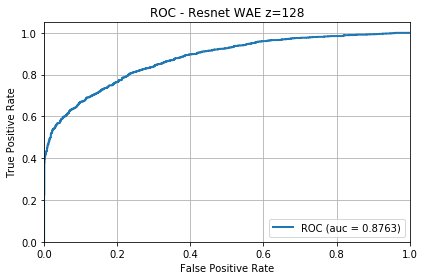

In [33]:
roc_auc = sklearn.metrics.roc_auc_score(gt, LLR[0])
fpr, tpr, thresholds = sklearn.metrics.roc_curve(gt, LLR[0])
print ('ROC-AUC: %.04f' % roc_auc)
# Plot and save ROC curve
fig = plt.figure()
plt.title('ROC - Resnet WAE z=128')
plt.plot(fpr, tpr, lw=2, label='ROC (auc = %0.4f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()